# Requirements

In [2]:
import os

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
import cv2

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from torch.autograd import Variable
from torch.optim import AdamW
from tqdm import tqdm

/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <A0E0B741-848C-3144-924F-2971884DA4EF> /Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <6384E44A-E10D-30C9-994F-E34B0519E5B3> /Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Dataset

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, paths, transforms = None, padding = None):
        super().__init__()
        self.paths = paths
        self.transforms = transforms
        self.pad = padding
        
    def __len__(self):
        return len(self.paths)
        
    def __getitem__(self, ind):
        
        img = cv2.imread(paths[ind])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.pad != None:
            img = self.pad(image = img)['image']
            
        if self.transforms != None:
            img = self.transforms(img)
        
        return img

In [4]:
root_dir = 'naruto-face-dataset'

In [5]:
paths = []

In [6]:
for folder in os.listdir(root_dir):
    if folder == '.DS_Store' or folder == '.ipynb_checkpoints':
        continue
    folder_path = os.path.join(root_dir, folder)
    for file in os.listdir(folder_path):
        if file == '.DS_Store' or file == '.ipynb_checkpoints':
            continue
        paths.append(os.path.join(folder_path, file))

In [7]:
transforms_ = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [8]:
dataset = Dataset(paths)

In [9]:
image_size = 128 
pad = A.Compose([
    A.PadIfNeeded(image_size, image_size, value = 0)
])

In [10]:
def weights_init_xavier(m):
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [11]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

T = 300
betas = linear_beta_schedule(timesteps=T)

alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [12]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

In [13]:
data_transforms = torchvision.transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((image_size, image_size)),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])

In [14]:
transformed_dataset = Dataset(paths, data_transforms, pad)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

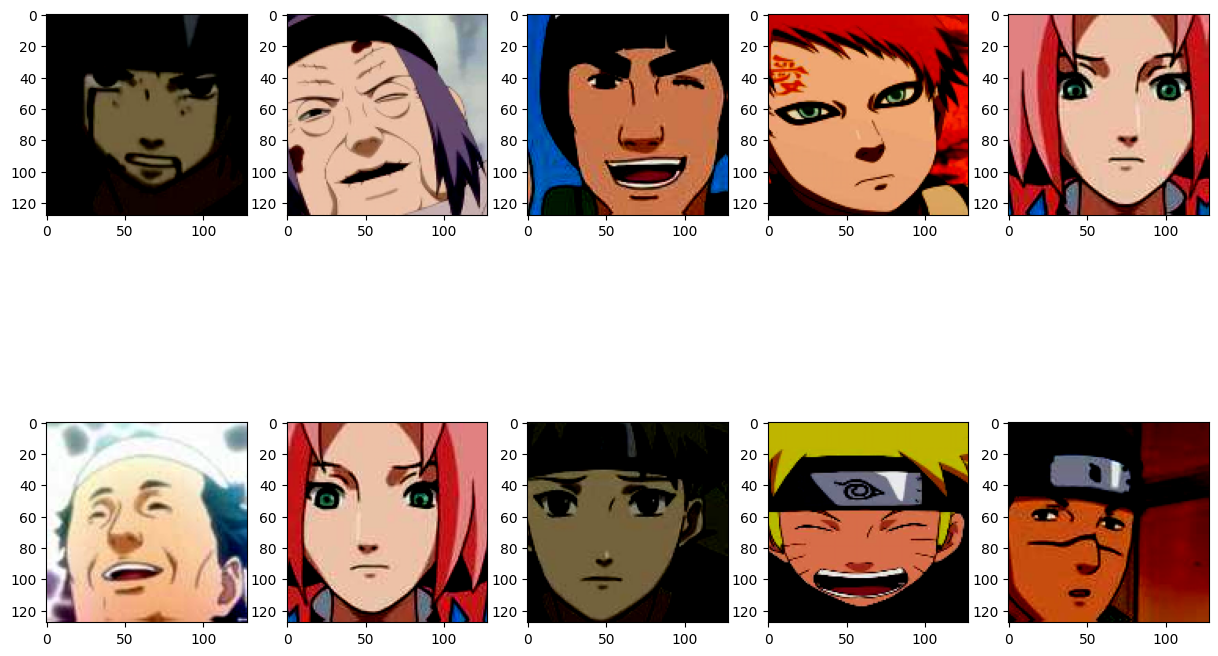

In [18]:
n_samples = 10
cols = 5
plt.figure(figsize=(15,15))
for i in range(n_samples):
    img = transformed_dataset[i].permute(1,2,0)
    plt.subplot(n_samples//cols + 1, cols, i + 1)
    plt.imshow(img)

In [43]:
image = transformed_dataset[0]

/var/folders/sm/zp4frk3174zc8vhh_l6v9byh0000gn/T/ipykernel_39039/3185400471.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


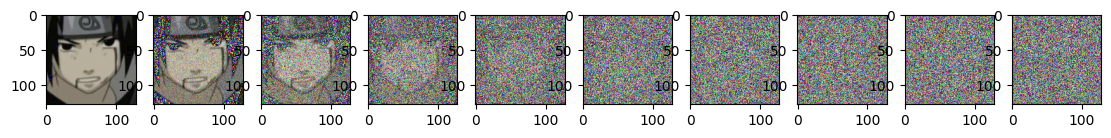

In [44]:
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.0),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(img.shape) == 4:
        img = img[0, :, :, :] 
    plt.imshow(reverse_transforms(img))

# Model

In [45]:
from torch import nn
import math


class downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding=1)
        self.transform = nn.Conv2d(out_channels, out_channels, kernel_size = 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_embedding = self.relu(self.time_mlp(t))
        time_embedding = time_embedding[(..., ) + (None, ) * 2]
        h = h + time_embedding
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)
    
class upsample_block(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_channels)
        self.conv1 = nn.Conv2d(2*in_channels, out_channels, kernel_size = 3, padding=1)
        self.transform = nn.ConvTranspose2d(out_channels, out_channels, kernel_size = 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_embedding = self.relu(self.time_mlp(t))
        time_embedding = time_embedding[(..., ) + (None, ) * 2]
        h = h + time_embedding
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU())
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], kernel_size = 3, padding=1)

        self.downs = nn.ModuleList([downsample_block(down_channels[i],
                                                     down_channels[i+1],
                                                     time_emb_dim) for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([upsample_block(up_channels[i],
                                        up_channels[i+1],
                                        time_emb_dim) for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [54]:
model = SimpleUnet()

In [47]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [48]:
@torch.no_grad()
def sample_timestep(x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    img_size = image_size
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

# Training

In [55]:
batch_size = 12
dataloader = DataLoader(transformed_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
device = 'mps'
model.to(device)
optimizer = AdamW(model.parameters(), lr=0.001)
epochs = 100
for epoch in range(epochs):
    step = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (batch_size,), device=device).long()
        loss = get_loss(model, batch, t)
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()
        step += 1